In [1]:
import importlib.util
import os
from copy import copy
from io import StringIO
from logging import (
    INFO,
    NOTSET,
    FileHandler,
    Formatter,
    Logger,
    StreamHandler,
    captureWarnings,
    getLogger,
)
from pathlib import Path
from shutil import rmtree

import matplotlib.pyplot as plt
import numpy as np
from ase.build import molecule
from ase.build.rotate import minimize_rotation_and_translation
from ase.geometry import get_dihedrals
from ase.io.trajectory import Trajectory
from ase.mep import NEB
from ase.optimize import FIRE, LBFGS
from ase.vibrations import Vibrations
from ase.visualize import view
from fairchem.core import FAIRChemCalculator
from fairchem.core.units.mlip_unit import load_predict_unit
from sella import Sella

/home/yu9824/opt/miniforge3/envs/fairchem312/lib/python3.12/site-packages/torchtnt/utils/version.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
jobname = "ethane-neb"

SEED = 334

In [3]:
if "__file__" in locals():
    DIRPATH_ROOT = Path(__file__).parent
else:
    DIRPATH_ROOT = Path(os.getcwd())

DIRPATH_TRAJ = DIRPATH_ROOT / "traj" / jobname
rmtree(DIRPATH_TRAJ, ignore_errors=True)
DIRPATH_TRAJ.mkdir(parents=True)

DIRPATH_LOG = DIRPATH_ROOT / "log" / jobname
rmtree(DIRPATH_LOG, ignore_errors=True)
DIRPATH_LOG.mkdir(parents=True)


In [4]:
def configure_logger() -> Logger:
    logger = getLogger("sella-tutorial")
    logger.propagate = False

    formatter = Formatter("%(asctime)s [%(levelname)s] %(message)s")

    file_handler = FileHandler(
        DIRPATH_LOG / "sella-tutorial.log",
        mode="w",  # 上書き
    )
    file_handler.setFormatter(formatter)
    file_handler.setLevel(NOTSET)

    if importlib.util.find_spec("colorlog"):
        from colorlog import ColoredFormatter

        colored_formatter = ColoredFormatter(
            "%(asctime)s [%(log_color)s%(levelname)s%(reset)s] %(message)s"
        )
    else:
        colored_formatter = formatter
    stream_handler = StreamHandler()
    stream_handler.setFormatter(colored_formatter)
    stream_handler.setLevel(NOTSET)

    captureWarnings(True)
    _logger_warnings = getLogger("py.warnings")
    _logger_warnings.handlers.clear()
    _logger_warnings.addHandler(file_handler)
    _logger_warnings.addHandler(stream_handler)
    _logger_warnings.propagate = False

    logger.handlers.clear()
    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)
    logger.setLevel(INFO)

    return logger


logger = configure_logger()

In [5]:
predictor = load_predict_unit(
    Path(os.environ["HOME"]) / "uma/checkpoints/uma-s-1p1.pt", device="cuda"
)
calc = FAIRChemCalculator(predictor, task_name="omol", seed=SEED)

In [6]:
# --- 0) ユーティリティ：Cと各Cに結合するHを見つける
def find_ch_groups(atoms, cutoff=1.3):
    positions = atoms.get_positions()
    symbols = atoms.get_chemical_symbols()
    C_idx = [i for i, s in enumerate(symbols) if s == "C"]
    H_idx = [i for i, s in enumerate(symbols) if s == "H"]
    # 簡易に距離でC-H結合を判定
    ch = {c: [] for c in C_idx}
    for c in C_idx:
        for h in H_idx:
            d = np.linalg.norm(positions[c] - positions[h])
            if d < cutoff:
                ch[c].append(h)
    C0, C1 = C_idx
    Hs0, Hs1 = ch[C0], ch[C1]
    # 各メチルから1つHを選び、H–C–C–Hの二面角を定義
    # return C0, C1, Hs0[0], Hs1[0]
    return C0, C1, Hs0, Hs1

In [7]:
# --- 1) 初期/最終構造の用意（エタン）
ethane = molecule("C2H6")  # 初期に一旦作成
C0, C1, Hs0, Hs1 = find_ch_groups(ethane)

mask = tuple(ind in set(Hs1) | {C0, C1} for ind in range(len(ethane)))


# --- ヘルパー関数: dihedral angle を degree で返す
def dihedral_angle(atoms, i, j, k, l):
    pos = atoms.get_positions()
    v0 = pos[j] - pos[i]  # i->j
    v1 = pos[k] - pos[j]  # j->k
    v2 = pos[l] - pos[k]  # k->l
    return get_dihedrals([v0], [v1], [v2])[0]  # degree


# 初期: -60° Staggered
initial = ethane.copy()
target_init_dihed = -60.0
initial.set_dihedral(
    Hs0[0],
    C0,
    C1,
    Hs1[0],
    target_init_dihed,
    mask=mask,
)
initial.calc = copy(calc)
initial.info["charge"] = 0
initial.info["spin"] = 1
opt_init = LBFGS(
    initial,
    logfile=str(DIRPATH_LOG / "initial.log"),
    trajectory=str(DIRPATH_TRAJ / "initial.traj"),
)
converged_init = opt_init.run(fmax=0.01)
logger.info(f"Converge initial structure: {converged_init}")

dihed_initial = dihedral_angle(initial, Hs0[0], C0, C1, Hs1[0])
logger.info(f"dihedral angle (initial): {dihed_initial} degree")
# dihed = dihedral_angle(ethane, Hs0[0], C0, C1, Hs1[0])


final = initial.copy()
target_final_dihed = 60.0  # degree
final.set_dihedral(
    Hs0[0],
    C0,
    C1,
    Hs1[0],
    target_final_dihed,
    mask=mask,
)

final.calc = copy(calc)
final.info["charge"] = 0
final.info["spin"] = 1
opt_final = LBFGS(
    final,
    logfile=str(DIRPATH_LOG / "final.log"),
    trajectory=str(DIRPATH_TRAJ / "final.traj"),
)
converged_final = opt_final.run(fmax=0.01)
logger.info(f"Converge final structure: {converged_final}")

dihed_final = dihedral_angle(final, Hs0[0], C0, C1, Hs1[0])
logger.info(f"dihedral angle (final): {dihed_final} degree")

2025-08-21 16:33:59,162 [INFO] Converge initial structure: True
2025-08-21 16:33:59,163 [INFO] dihedral angle (initial): 299.9999316289081 degree
2025-08-21 16:33:59,267 [INFO] Converge final structure: True
2025-08-21 16:33:59,269 [INFO] dihedral angle (final): 59.999999999999986 degree


In [8]:
# 座標の違いを最小にする
minimize_rotation_and_translation(initial, final)

view((initial, final), viewer="ngl")

In [9]:
# --- 2) NEB 準備
n_images = 5  # 中間像の数（増やすと経路がなめらか）
images = [initial]
images += [initial.copy() for _ in range(n_images)]
images += [final]

neb = NEB(images, k=0.1, climb=True)
neb.interpolate(method="idpp")

# 計算器
for im in images:
    im.info["charge"] = 0
    im.info["spin"] = 1
    im.calc = copy(calc)


In [10]:
# --- 3) NEB 最適化
opt_neb = FIRE(
    neb,
    logfile=str(DIRPATH_LOG / "neb.log"),
    trajectory=str(DIRPATH_TRAJ / "neb.traj"),
)
converged_neb = opt_neb.run(fmax=0.05, steps=1000)
logger.info(f"NEB converged: {converged_neb}")

2025-08-21 16:34:13,659 [INFO] NEB converged: True


In [11]:
# --- 4) 最高エネルギー像をTS初期候補として抽出
energies = np.array([a.get_potential_energy() for a in images])
energies -= energies.min()
ts_idx = int(np.argmax(energies))
ts_guess = images[ts_idx]

logger.info(
    f"NEB images: {len(images)}, TS guess index: {ts_idx}, E[max]-E[0] = {energies[ts_idx]:.3f} eV"
)

2025-08-21 16:34:13,842 [INFO] NEB images: 7, TS guess index: 3, E[max]-E[0] = 0.112 eV


In [12]:
view(images, viewer="ngl")

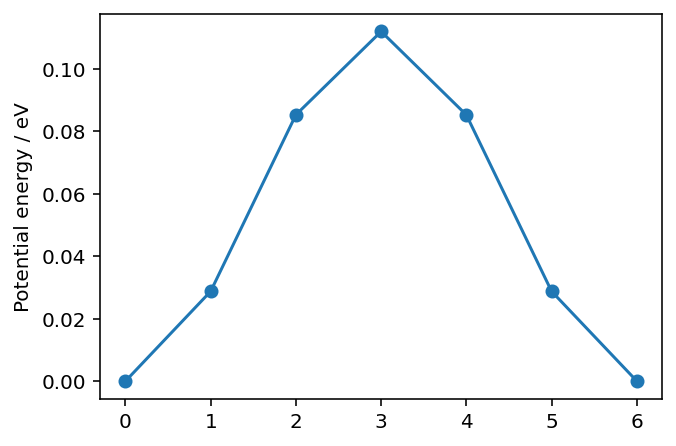

In [13]:
fig, ax = plt.subplots(dpi=144, figsize=(4.8, 3.2))
ax.plot(energies, marker="o")
ax.ticklabel_format(style="plain", useOffset=False)
ax.set_ylabel("Potential energy / eV")
fig.tight_layout()

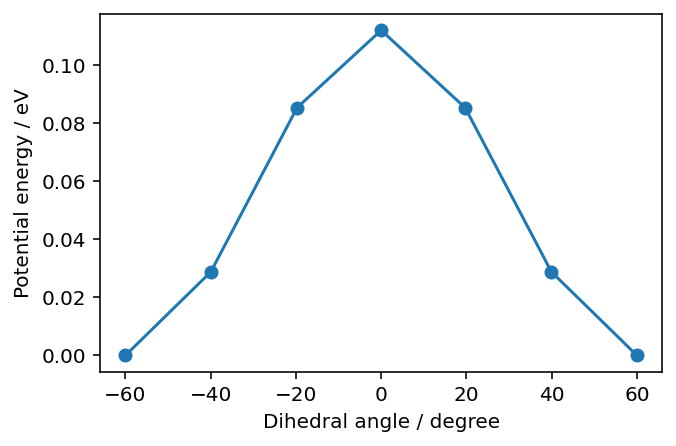

In [14]:
arr_dihedral_angles = np.asarray(
    [
        dihedral_angle(images[frame], Hs0[0], C0, C1, Hs1[0])
        for frame in range(len(images))
    ]
)
arr_dihedral_angles[arr_dihedral_angles > 180] -= 360

fig, ax = plt.subplots(dpi=144, figsize=(4.8, 3.2))
ax.plot(arr_dihedral_angles, energies, marker="o")
ax.ticklabel_format(style="plain", useOffset=False)
ax.set_xlabel("Dihedral angle / degree")
ax.set_ylabel("Potential energy / eV")
fig.tight_layout()

In [15]:
# --- 5) Sella で遷移状態探索（opt='ts'）
ts_structure = ts_guess.copy()

ts_structure.calc = copy(calc)
ts_structure.info["charge"] = 0
ts_structure.info["spin"] = 1
ts_structure.set_constraint()
opt_ts = Sella(
    ts_structure,
    trajectory=str(DIRPATH_TRAJ / "ts.traj"),
    logfile=str(DIRPATH_LOG / "ts.log"),
    order=1,  # ← index-1 saddle を探す
    eta=1e-4,  # 初期ステップサイズ。大きくすると高速に移動、小さくすると安定だが遅い
    gamma=0.01,  # 反復パラメータ（Sella 固有）。勾配の反映具合を調整
    internal=True,  # 内部座標系で最適化するか。
    diag_every_n=1,
)
converged_ts = opt_ts.run(fmax=1e-4)
logger.info("Sella TS search finished. See ts.traj / ts.log")
logger.info(f"Converge TS: {converged_ts}")


2025-08-21 16:34:40,472 [INFO] Sella TS search finished. See ts.traj / ts.log
2025-08-21 16:34:40,475 [INFO] Converge TS: True


In [16]:
dihedral_angle(ts_structure, Hs0[0], C0, C1, Hs1[0])

np.float64(0.15870478500850113)

In [17]:
view(ts_structure, viewer="x3d")

In [18]:
# --- 6) 振動数計算
dirpath_vib_cache = DIRPATH_TRAJ / "cache"

# 遷移状態の構造を読み込み
# ts_structure = read("ts.traj", index=-1)  # 最後の構造を取得
ts_structure.calc = copy(calc)
ts_structure.info["charge"] = 0
ts_structure.info["spin"] = 1

# 振動数計算の設定
vib = Vibrations(
    ts_structure, delta=0.01, name=str(dirpath_vib_cache), nfree=2
)  # delta: 有限差分のステップサイズ（Å）

vib.clean()
# 振動数計算を実行
vib.run()

frequencies = vib.get_frequencies()
flag_imag_freq = ~np.isclose(frequencies.imag, 0.0)
n_imag_freqs = np.sum(flag_imag_freq).item()
# 結果の表示
logger.info("=== 振動数計算結果 ===")
logger.info(f"虚振動の数: {n_imag_freqs} / {flag_imag_freq.shape[0]}")

# 虚振動数の詳細表示
str_imag_freqs = "虚振動数 (cm^-1):"
if n_imag_freqs:
    for idx, freq in enumerate(frequencies):
        if flag_imag_freq[idx]:
            str_imag_freqs += f"\n  {idx}: {freq:8.2f}"
            # 虚振動のモードを可視化
            vib.write_mode(idx)
            (
                dirpath_vib_cache.parent
                / f"{dirpath_vib_cache.name}.{idx}.traj"
            ).rename(dirpath_vib_cache.parent / f"{jobname}.{idx}.traj")

    logger.info(str_imag_freqs)

buffer_io = StringIO()
vib.summary(log=buffer_io)
logger.info(f"\n{buffer_io.getvalue()}")

2025-08-21 16:34:45,136 [INFO] === 振動数計算結果 ===
2025-08-21 16:34:45,137 [INFO] 虚振動の数: 4 / 24
2025-08-21 16:34:45,153 [INFO] 虚振動数 (cm^-1):
  0: 0.00+277.78j
  1: 0.00+6.83j
  2: 0.00+0.35j
  3: 0.00+0.12j
2025-08-21 16:34:45,154 [INFO] 
---------------------
  #    meV     cm^-1
---------------------
  0   34.4i    277.8i
  1    0.8i      6.8i
  2    0.0i      0.3i
  3    0.0i      0.1i
  4    0.0       0.3
  5    4.2      34.2
  6   11.4      92.3
  7  110.8     893.6
  8  111.6     900.3
  9  126.1    1016.8
 10  144.7    1167.4
 11  145.1    1170.2
 12  173.3    1397.9
 13  177.9    1434.8
 14  184.9    1491.6
 15  185.1    1492.7
 16  186.1    1501.3
 17  186.2    1501.8
 18  379.8    3063.3
 19  380.7    3070.6
 20  385.9    3112.2
 21  386.2    3114.7
 22  388.5    3133.8
 23  388.9    3136.8
---------------------
Zero-point energy: 2.029 eV



In [19]:
ind = 0
traj_vib = Trajectory(DIRPATH_TRAJ / f"{jobname}.{ind}.traj")
# write(f"vib.{ind}.gif", traj_vib, format="gif")
view(traj_vib, viewer="ngl")
